In [1]:
from dolfinx import fem, mesh, plot, io, geometry
from dolfinx.fem.petsc import LinearProblem
from petsc4py.PETSc import ScalarType
from mpi4py import MPI
import numpy as np
from ufl import ds, dx, grad, inner
import ufl
import matplotlib as mpl
import pyvista
from typing import List, Tuple

import sys
import os
# Get the absolute path to the src directory
src_path = os.path.abspath('..')
if src_path not in sys.path:
    sys.path.append(src_path)

from src.visualization import timeDependentVariableToGif, plot_array, plot_function
from src.solveStateEquation import solveStateEquation, getSourceTerm, buildControlFunction
from src.solveAdjointEquation import solveAdjointEquation
from src.solveFinDimObjective import solveFinDimProblem
from src.tools import getValueOfFunction, buildIterationFunction
from src.ExtremalPoints import ExtremalPoint
from src.HesseMatrix import calculateL2InnerProduct, HesseMatrix
from src.semiSmoothNewtonSolver import computeSemiNewtonStep, computeObjective
from dataclasses import dataclass

@dataclass
class Parameters:
    T = 1
    dt = 0.01
    x1 = (0.5, 0.5)
    x2 = (-0.5, -0.5)
    area = 4
    d = 2
    mollify_const = 0.001
    newton_c = 1
    eta = 0.01
    alpha = 0.1
    beta = 0.005
    waveSpeed = 1
    gamma = 0.000
    maxNewtonSteps = 200
    randomFactor = 0.05
    yd = []
    msh = mesh.create_rectangle(
        comm=MPI.COMM_WORLD,
        points=((-1., -1.), (1.0, 1.0)),
        n=(32, 32),
        cell_type=mesh.CellType.triangle,
    )
    V = fem.functionspace(msh, ("Lagrange", 1))

In [2]:

params = Parameters()

active_set = []
new_point = ExtremalPoint(np.array([1, 0]), 0.5, type=0, params=params, idx=int(0.5/params.dt))
active_set.append(new_point)
new_point = ExtremalPoint(np.array([1, 0]), 0.2, type=0, params=params, idx=int(0.2/params.dt))
active_set.append(new_point)
hesseMatrix = HesseMatrix(active_set, params)
weights = np.ones(len(active_set)) * params.alpha
slope = np.zeros((params.d,))
y_shift = np.zeros((params.d,))
u_1 = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)[0]
u_2 = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)[1]
#plot_function(lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params), params.T, params.dt, label='original')
g1 = getSourceTerm(params.x1, params)
g2 = getSourceTerm(params.x2, params)
control = buildControlFunction([g1, g2], [u_1, u_2], params)
yd = solveStateEquation(control, params)
params.yd = yd

print('Upper bound objective value:', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesseMatrix.standard_states, params))
params.newton_c = 100
weights = np.ones(len(active_set))
slope = np.zeros((params.d,))
y_shift = np.zeros((params.d,))
active_set = []
new_point = ExtremalPoint(np.array([1, 0]), 0.5, type=0, params=params, idx=int(0.5/params.dt))
active_set.append(new_point)
new_point = ExtremalPoint(np.array([1, 0]), 0.2, type=0, params=params, idx=int(0.2/params.dt))
active_set.append(new_point)
#print('cond: ', np.linalg.cond(hesseMatrix.matrix))
#timeDependentVariableToGif(params.yd, 'output/observation.gif', slowMoFactor=2, T=params.T)
#weights[:] = 0
print('Newton parameter: ', params.newton_c)
weights, slope, y_shift = computeSemiNewtonStep(weights, slope, y_shift, active_set, hesseMatrix, params)
#print('newton weight:', weights, ' slope: ', slope, 'y_shift:', y_shift)
weights = np.ones(len(active_set))
slope = np.zeros((params.d,))
y_shift = np.zeros((params.d,))
params.newton_c = 0.1
print('Newton parameter: ', params.newton_c)
weights, slope, y_shift = computeSemiNewtonStep(weights, slope, y_shift, active_set, hesseMatrix, params)


Upper bound objective value: 0.2
Newton parameter:  100
0 : Objective value:  31.679271559170417
1 : Objective value:  29.784822356455464
2 : Objective value:  4.272975774195272
3 : Objective value:  4.639630901403996
4 : Objective value:  0.04652565139840864
5 : Objective value:  0.0010058236418784333
6 : Objective value:  0.003400747487354008
7 : Objective value:  0.0027307900875262977
8 : Objective value:  0.002849025607027106
9 : Objective value:  0.0028264912065421115
10 : Objective value:  0.002830724617491148
11 : Objective value:  0.0028299267893227716
12 : Objective value:  0.002830077133682508
13 : Objective value:  0.00283004878653488
14 : Objective value:  0.0028300541339089116
Newton solution:  [ 0.          0.          2.13564011  0.01268415  0.15517728 -0.00620764]
Newton parameter:  0.1
0 : Objective value:  32.34871449656927
1 : Objective value:  761.794493155208
2 : Objective value:  4.55001028887248
3 : Objective value:  4.928685285672494
4 : Objective value:  343.06

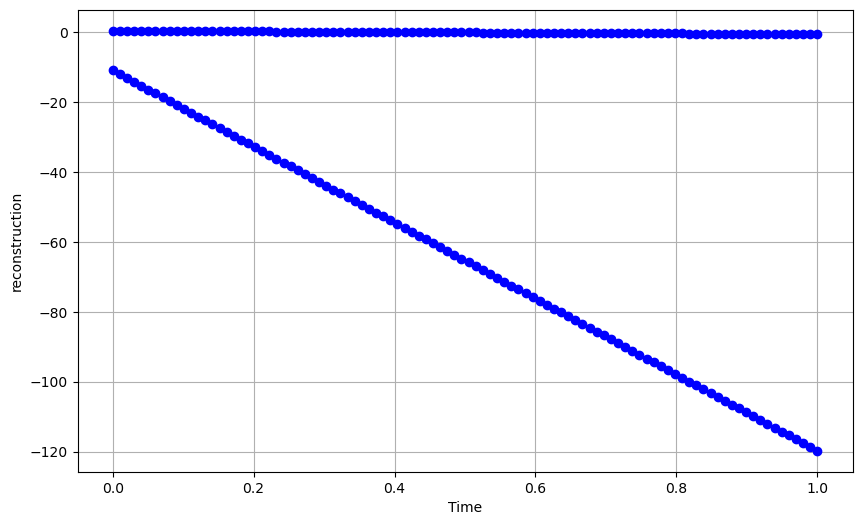

In [3]:
reconstruction_0 = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)[0]
reconstruction_1 = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)[1]

control = buildControlFunction([g1, g2], [reconstruction_0, reconstruction_1], params)
state = solveStateEquation(control, params)
#timeDependentVariableToGif(state, 'output/new_state.gif', slowMoFactor=2, T=params.T)
#timeDependentVariableToGif(control, 'output/reconstruction.gif', slowMoFactor=2, T=params.T)
plot_function(lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params), params.T, params.dt, label='reconstruction')
#print(weights / params.alpha)
#print(slope)
#print(y_shift)
#print(active_set[0].x_0)


'''
weight = 2
gamma = 0
phi = [fem.Function(params.V) for _ in params.yd]
hesse = calculateL2InnerProduct(new_point.state, new_point.state, params) + gamma
standard = calculateL2InnerProduct(yd, new_point.state, params)
q = weight + 1/params.newton_c
for k in range(20):
    P_c = max(q - 1/params.newton_c, 0)
    #print(k, ': q:', q)
    #print(k, ': x:', P_c)
    DP_c = 1. if q - 1/params.newton_c >= 0 else 0.
    Df = q * hesse - standard + gamma * q
    G = params.newton_c * (q - P_c) + Df
    DG = params.newton_c * (1 - DP_c) + hesse * DP_c
    #print('DG: ', DG)
    #print('Df')
    dq = -G/DG
    q = q + dq

print('weight:', max(q - 1/params.newton_c, 0))
#plot_function(lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params), params.T, params.dt)
'''